In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Q1

### Part a) Perceptron Algorithm

In [232]:
#This code block defines the perceptron algorithm
def perceptron(x,y,w0,totalprev):
    n = y.size
    w = w0
    stack = np.array([10]*totalprev)
    tol = 1e-8
    t = 0
    while(np.sum(stack)>tol):
        stack = np.delete(stack,0)
        num = np.random.randint(0,n) # random row number to choose for GD
        xn = np.array(x.iloc[num])
        yn = int(y.iloc[num])
        if(np.dot(w,xn)*yn<0):
            wnew = w+yn*xn
            diff = np.sum(np.abs(wnew-w))
            stack = np.append(stack,diff) # "diff" amount of change found
            w = wnew
        else:
            stack = np.append(stack,0) # no change found hence append 0
        t+=1 # iterations track
    return w

### Part b) Perceptron with UCI Bank Note Dataset 
[Dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)

In [ ]:
#load dataset
header = ["Variance", "Skewness", "Curtosis", "Entropy", "Class"]
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', names=header)
df

In [ ]:
df['Class'] = df['Class'].apply(lambda x: x*2-1) #transforming the 0/1 classes to -1/1 in dataset column
X = df[["Variance", "Skewness", "Curtosis", "Entropy"]] #selecting the X
y = df["Class"] #selecting the y

In [58]:
#this function defines splitting of dataset into train, test split based on a given condition
def train_test_split(X, y, ratio):
  msk = np.random.rand(n) < ratio
  X_train = X[msk]
  X_test = X[~msk]
  y_train = y[msk]
  y_test = y[~msk]

  return X_train, y_train, X_test, y_test

### Predict Function for Perceptron Algorithm

In [234]:
def predict(X, w):
    y = np.dot(X,w) >= 0 # actual_y = [+1, 0]
    y_pred = y*2  - 1  # y_predicted transformed from 0,1 to -1,1
    return y_pred

# function to calculate accuracy
def accuracy(y_test, y_pred):
    total = np.sum(np.abs(y_pred != y))
    return (1 - (total / y.shape[0])) * 100

##### **Data Pre-Processing**
1. Shuffle the dataset to remove bias while training the model, if any
2. No missing values or anomaly in the data

In [215]:
n = len(X)
nt = 1 #learning rate
# preprocess the data
np.random.seed(786) #setting the random seed
df = df.sample(frac=1).reset_index(drop=True) # shuffling data
w_init = np.random.normal(1, 0, (4, )) # initializing the weight vector

In [237]:
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8) #80% train + 20% test split

Testing the pereptron algorithm by training on train set and calculating accuracy on test set

In [241]:
w_percep = perceptron(X_train, y_train, w_init,100) #perecptron algo return weights
y_pred = predict(X, w_percep) #calculate predicted labels of class using weights from training data
acc = accuracy(y_test, y_pred) #calculating accuracy
print(" Test Data Accuracy:",acc, "%")

 Test Data Accuracy: 95.77259475218659 %


### Part c

#### **Cross Validation**

In [307]:
def Kfold_crossVal(X, y, w0, n_folds):
    np.random.seed(786)
    cross_accumulate = []
    num_lst = np.arange(y.size)   # used for splitting into training and test in cv
    np.random.shuffle(num_lst) # for randomness
    split = np.array_split(num_lst, n_folds) # K folds split

    for i in split:
        curr_split = np.zeros(y.size)
        curr_split[i] = 1 # choose this fold for testing and other folds for training in this iteration
        msk = np.array(curr_split, dtype = 'bool') # represents test set
        xtest = X[msk] #selecting test set
        xtrain = X[~msk] #conjugate of test set
        ytest = y[msk]
        ytrain = y[~msk]
        wCV = perceptron(xtrain, ytrain, w_init, 100) #cross val weights from perceptron algo
        y_pred = predict(xtest, wCV) #cross val predictions
        curr_accuracy = 1 - np.sum(np.abs(y_pred != ytest)) / len(ytest)
        cross_accumulate.append(curr_accuracy)
        
    cross_accumulate = np.array(cross_accumulate)
    return np.mean(cross_accumulate)

#### **Cross Validation Test Error**

In [306]:
folds = 10 # no of folds in kfold cross validation
score =  Kfold_crossVal(X, y, w_init, folds) * 100
error = 100-score
print("Cross Validation Test Error %: ", error) # using training set for CV 

Cross Validation Test Error %:  5.249656193800902


### Part d) **Calculating F1 Score**

In [270]:
np.random.seed(786)
train, valid, test =  np.split(df.sample(frac=1, random_state=42), [int(.7*len(df)), int(.9*len(df))]) #create new splits for train, test, val as we need f1 using a held out validation set
# 70/10/20 split
xtrain = train.iloc[:, :-1]
ytrain = train.iloc[:, -1]

xtest = test.iloc[:, :-1]
ytest = test.iloc[:, -1]

xval = valid.iloc[:, :-1]
yval = valid.iloc[:, -1]

Class Labels: -1/+1
*   **F1** Score for held out data set, where held out data set is validation set 
*   Use weights we get from training data


In [308]:
w_training = perceptron(xtrain, ytrain, w_init, 100) #training weights from perceptron algo
ypred_out = predict(xval, w_training) #predictions on held out set
tp = np.sum(np.logical_and(ypred_out == 1 , np.array(yval) == 1)) # True positive
fp = np.sum(np.logical_and(ypred_out == 1 , np.array(yval) == -1)) # False positive
tn = np.sum(np.logical_and(ypred_out == -1 , np.array(yval) == -1)) # True Negative
fn = np.sum(np.logical_and(ypred_out == -1 , np.array(yval) == 1)) # False Negative

prec = tp / (tp + fp) #precision
rec = tp / (tp + fn) #recall
F1 = (2 * (prec * rec) )/ (prec + rec)
print("F1 Score on Held Out Validation Set : ", F1)

F1 Score on Held Out Validation Set :  0.956896551724138


# Q2

### Part a)
The Probability Density Function for Gaussian can be defined as:<br><br>
$\mathcal{N(\mu, \sigma^{2})} =\frac{1}{\sqrt{2\pi } \sigma }\exp\left( -\frac{( x\ -\ \mu )^{2}}{2\sigma ^{2}}\right)$

In [292]:
#function defining gaussian pdf
def gaussian_pdf(x, mu, sig):
    return 1 / (np.sqrt(2 * np.pi) * sig) * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [275]:
mu_data = 10 #mean for data
mu_prior = 25 #mean of prior
sd_data = 5 #std dev of data
sd_prior = 5 #std dev of prior
N = 50 #no. of points
X_data = np.random.normal(mu_data, sd_data, N) # Derived synthetic data based on given conditions

Let the likelihood be given as => $p( x_{n} \ |\ \mu ) \ =\mathcal{N}( \mu ,\ \sigma^{2} ) \ \forall x_n \ \text{as given in } \text{data}$
<br>
Where $\mu$ is unknown but $\sigma$ is not
<br>
And prior be 
<br>
$p( \mu ) \ =\ \mathcal{N}( \mu _{o} ,\ \sigma^{2} _{o})$
<br>
Then the posterior accoording to Bayes theorem will be: 
<br>
$
\begin{align*}
 p( \mu |\mathbf{X}) \ & \varpropto p(\mathbf{X} |\mu ) .p( \mu )\\
& \varpropto \prod_{n=1}^{N} \exp\left[ -\frac{( x_{n} \ -\ \mu )^{2}}{2\sigma ^{2}}\right] \times \exp\left[ -\frac{( \mu -\mu _{o})^{2}}{2\sigma _{o}^{2}}\right]\\
&\varpropto \exp\left[ -\frac{( \mu -\mu _{N})^{2}}{2\sigma _{N}^{2}}\right]
\end{align*}
$
<br>
Where
<br>
$
\begin{align*}
\mu _{N} \ &=\frac{\sigma ^{2}\mu _{o} + N\sigma _{o}^{2}\overline{x} }{N\sigma _{o}^{2} +\sigma ^{2}} \\
\sigma _{N}^{2} &=\frac{\sigma _{o}^{2}  . \sigma ^{2}}{N\sigma _{o}^{2} +\sigma ^{2}}
\end{align*}
$
<br>
$p( \mu |\mathbf{X}) \ =\ \mathcal{N}( \mu _{N} ,\ \sigma^{2} _{N})$
<br>
Posterior is also a gaussian with mean $\mu_N$ and variance $\sigma_N^{2}$

#### Calculating posterior $\mu$ and $\sigma$ using analytic expression derived above

In [294]:
mu_post = ((sd_data**2) / (N * (sd_prior**2) + sd_data**2)) * (mu_prior) + (N * sd_prior**2) / (N*sd_prior**2 + sd_data**2) * np.mean(X_data)
sd_post = np.sqrt((sd_data**2 * sd_prior**2) / (sd_data**2 + N * sd_prior**2))
print("Mean",mu_post)
print("Sigma_sq",sd_post**2) # mean and variance of posterior analytical

Mean 9.069248150373866
Sigma_sq 0.4901960784313726


#### Plots of Prior, Likelihood and Posterior 

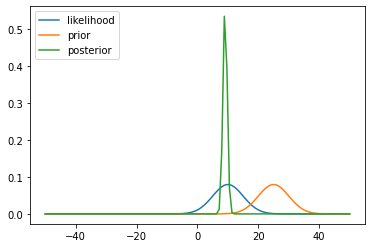

In [293]:
ax = np.linspace(-50, 50, 120) # points for density plots
y_likelihood = gaussian_pdf(ax, mu_data, sd_data) # likelihood: gaussian with given mean and variance
y_prior = gaussian_pdf(ax, mu_prior, sd_prior) # prior: gaussian with given mean and variance
y_post = gaussian_pdf(ax, mu_post, sd_post) # posterior: gaussian with derived mean and variance
plt.plot(ax, y_likelihood)
plt.plot(ax, y_prior)
plt.plot(ax, y_post)
plt.legend(["likelihood", "prior", "posterior"], loc ="upper left")
plt.show()

We have $\mu_{posterior} = 10$ and $\sigma_{posterior} = 0.7$ <br>
We can see that the posterior mean **(MAP)** is near to the likelihood mean, but it is also impacted by the prior and is a weighted sum of the prior and likelihood. 

## Part b

#### $f(z)$ is used in MH algorithm , and should be proportional to posterior upto a constant
Therefore, we have
$
\begin{align*}
f( \mu ) \ \varpropto \ p( \mu |\mathbf{X}) \ =\ \prod _{n=1}^{N}\exp\left[ -\frac{( x_{n} \ -\ \mu )^{2}}{2\sigma ^{2}}\right] \times \exp\left[ -\frac{( \mu -\mu _{o})^{2}}{2\sigma _{o}^{2}}\right]
\end{align*}
$

In [309]:
def f(z):
    rest = np.exp(-(z - mu_prior)**2 / (2 * sd_prior**2))
    for i in range(N):
        rest *= (np.exp(-(X_data[i] - z)**2 / (2 * sd_data**2)))
    return rest

### Metropolis Hastings Algorithm
1. It accepts as parameters the number of samples $n$ and the width of the proposed distribution.

2. The proposed distribution is Normal (previous sample, width^2).

3. It determines the probability of success from $f(z)$, which is the posterior probability.

4. From the posterior distribution, it returns $n$ samples. 

In [281]:
def MH_Sampling(L, width):
    np.random.seed(786)
    x_prev = 0 # previous sample
    samples = [] # list of all samples
    samples.append(x_prev)
    tol = 1e-1
    for l in range(L): # sample total L smaples
        x_proposed = np.random.normal(x_prev, width) # proposed sample from proposal distribution with sd = width
        u = np.random.uniform(0, 1, 1) # uniform Random Variable
        prob = min(1, f(x_proposed) / f(x_prev))
        if prob > u:
            samples.append(x_proposed) # denotes success
            x_prev = x_proposed
        else:
            samples.append(x_prev) # denotes failure: keep the previous val
        # early stopping due to reaching convergence
        
        if abs(np.mean(samples) - mu_post) < tol and abs(np.sqrt(np.var(samples)) - sd_post) < tol: # convergence condition: compare from analytical values and see if both mean and sd of samples is closer to actual value
            break
    return samples

In [296]:
## 10000 samples for Metropolis Algo Posterior and the Analytic posterior
sample_post = MH_Sampling(10000, 5)
analytic_post = np.random.normal(mu_post, sd_post, len(sample_post))

#### Histogram for Analytical posterior v/s Metropolis Hastings Sample posterior

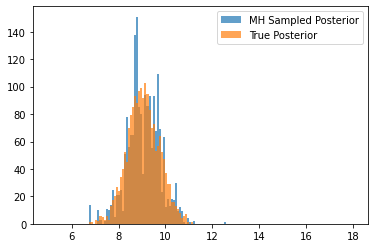

In [297]:
bins = np.linspace(5, 18, 150)
plt.hist(sample_post, bins, alpha=0.7, label='MH Sampled Posterior')
plt.hist(analytic_post, bins, alpha=0.7, label='True Posterior')
plt.legend(loc='upper right')
plt.show()

### Part c) **Compare time taken to converge with respect to proposal width**

In [284]:
### Small width to see time taken to converge to actual value 
%timeit MH_Sampling(5000, 0.01) 
%timeit MH_Sampling(5000, 5)

1 loop, best of 5: 2.74 s per loop
1 loop, best of 5: 940 ms per loop


As we can see clearly from above cell, the time taken to converge for narrow width proposal is greater as compared to the one with larger proposal width.
<br>
The following reasons can be attributed for it:

A. Because the width is narrow, the MH samples are highly linked.<br>
B. Because the MH samples are closer together, they are unable to cover much of the true posterior region.<br>
C. It takes too long for them to get all available MH samples in sufficient quantities to converge. 

### **Finding optimal Proposal Width**
1. If the proposal width is too broad, we will propose MH samples that are far from the mean, which will result in the rejection of the majority of them and sluggish convergence.
2. If the breadth is too narrow, the MH samples will become heavily linked and impossible to reach spots that are likely in the future.
3. We should discover the ideal width for MH samples that are reasonably uncorrelated and require a short period of time. 

In [298]:
width = np.linspace(1, 10, 10) # 10 widths from 1 to 5
res = {}
for w in width:
    samples = MH_Sampling(5000, w)
    res[w] = (abs(np.mean(samples) - mu_post) + abs(np.sqrt(np.var(samples)) - sd_post))

In [299]:
res #width is key and error is value in dictionary

{1.0: 0.10886502096858686,
 2.0: 0.1047186536858482,
 3.0: 0.10022929498444899,
 4.0: 0.1567124129538351,
 5.0: 0.127138973428077,
 6.0: 0.14626330747919136,
 7.0: 0.12567377317644135,
 8.0: 0.10087507314110167,
 9.0: 0.19217707509855764,
 10.0: 0.1816725600647977}

As measure of error, we have utilised *deviation* from real posterior $\mu$ combined with deviation from actual posterior $\sigma$.<br>
As the MH samples are uncorrelated and closer to real values, their $\mu$ will be near to the actual values, and their $\sigma$ will be close as well, resulting in a very minimum variation. 

### **Optimal Proposal Width**

Optimal Width = Width which gives min error which in turn means that samples are closest to posterior

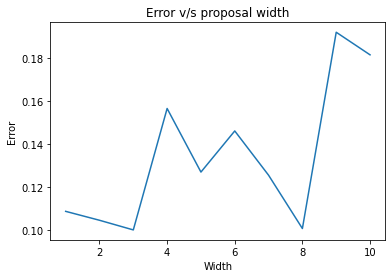

In [301]:
plt.plot(list(res.keys()), list(res.values()))
plt.xlabel('Width')
plt.ylabel('Error')
plt.title('Error v/s proposal width')
plt.show()

As we can see from the curve proposal width of 3 gave the minimum error. Hence it is the optimal proposal width.<br>
*Optimal Width = 3*

### **Consequences of using sub-optimal proposal width and terminating sampling soon**

We anticipate that the MH samples will be strongly linked and so will not be valid posterior samples. 

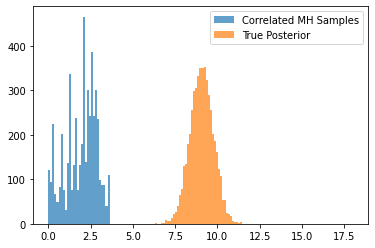

In [302]:
corr_samp = MH_Sampling(5000, 0.01)
analytic_post = np.random.normal(mu_post, sd_post, len(corr_samp))
bins = np.linspace(0, 18, 150)

plt.hist(corr_samp, bins, alpha=0.7, label='Correlated MH Samples')
plt.hist(analytic_post, bins, alpha=0.7, label='True Posterior')
plt.legend(loc='upper right')
plt.show()

As can be seen, MH samples are closer to the beginning value due to their narrow width and were unable to attain convergence due to early stopping. 